In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import numpy as np
import graphviz
import json

#### Load the Lending Club dataset

In [2]:
loans = pd.read_csv(r"D:\Classification\Project 4\data\lending-club-data.csv")

C:\Users\Govind\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Exploring some features

In [3]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [4]:
print(loans.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [5]:
loans[['bad_loans']].head() #1 means risky, 0 means safe

,bad_loans
0,0
1,1
2,0
3,0
4,0


In [6]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
del loans['bad_loans']

In [7]:
loans[['safe_loans']].head() #1 means risky, 0 means safe

,safe_loans
0,1
1,-1
2,1
3,1
4,1


In [8]:
print("percentage of safe loan is",100*sum(loans['safe_loans']==1)/len(loans))
print("percentage of bad  loan is",100*sum(loans['safe_loans']==-1)/len(loans))

percentage of safe loan is 81.11853319957262
percentage of bad  loan is 18.881466800427383


It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

#### Features for the classification algorithm

In [9]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

In [10]:
loans.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00,-1
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,1
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,1
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,1


#### One-hot encoding

In [11]:
categorical_var = [m for m in loans.columns if loans[m].dtypes == 'object']
categorical_var

['grade', 'sub_grade', 'home_ownership', 'purpose', 'term']

In [12]:
loans=pd.get_dummies(loans)

In [13]:
loans.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.00,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.00,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,11,8.72,1,1,98.5,0.00,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,11,20.00,0,1,21.0,16.97,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,4,11.20,1,1,28.3,0.00,1,1,0,...,0,0,0,0,0,0,0,1,1,0


In [14]:
with open(r"D:\Classification\Project 4\data\train-idx.json") as f:
    train_index=json.load(f)

with open(r"D:\Classification\Project 4\data\validation-idx.json") as f:
    valid_index=json.load(f)

In [15]:
train_data=loans.iloc[train_index]
validation_data=loans.iloc[valid_index]

In [16]:
train_data.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
1,1,1,1.00,1,1,9.4,0.0,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,5,5.55,1,1,32.6,0.0,-1,0,0,...,0,0,0,0,0,1,0,0,0,1
7,1,1,18.08,1,1,36.5,0.0,-1,0,1,...,0,0,0,0,1,0,0,0,0,1
10,1,1,10.08,1,1,91.7,0.0,-1,0,0,...,0,0,0,0,0,0,0,0,1,0
12,0,4,7.06,1,1,55.5,0.0,-1,0,1,...,0,0,0,0,1,0,0,0,1,0


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we undersampled the larger class (safe loans) in order to balance out our dataset. This means we have thrown away many data points.

In [17]:
print("percentage of safe loan is",
      100*((sum(train_data['safe_loans']==1)+sum(validation_data['safe_loans']==1))/(len(train_data)+len(validation_data))))
print("percentage of bad  loan is",
      100*((sum(train_data['safe_loans']==-1)+sum(validation_data['safe_loans']==-1))/(len(train_data)+len(validation_data))))

percentage of safe loan is 50.22361744216048
percentage of bad  loan is 49.77638255783951


#### Build a decision tree classifier

In [18]:
decision_tree_model = DecisionTreeClassifier(max_depth=6)

In [19]:
small_model = DecisionTreeClassifier(max_depth=2)

In [20]:
x=train_data.drop('safe_loans',axis=1)

In [21]:
decision_tree_model.fit(x,train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
small_model.fit(x,train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Visualizing a learned model

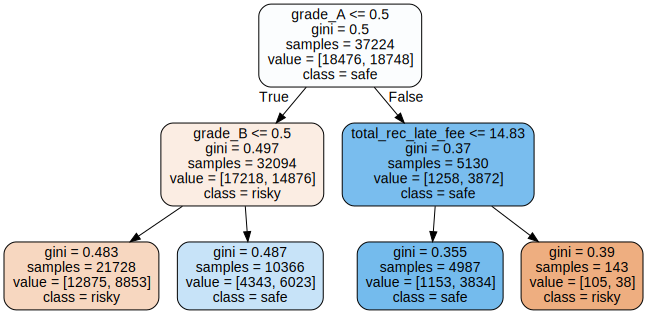

In [23]:
export_graphviz(small_model, out_file=r"D:\Classification\Project 4\data\validation-idx.json",
               feature_names=x.columns,class_names=['risky','safe'],filled=True,rounded=True)
with open(r"D:\Classification\Project 4\data\validation-idx.json") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### Making predictions

In [24]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
decision_tree_model.predict(sample_validation_data.drop('safe_loans',axis=1))

array([ 1, -1, -1,  1], dtype=int64)

decision_tree_model get 50% of the predictions on sample_validation_data correct.

#### Explore probability predictions

In [26]:
decision_tree_model.predict_proba(sample_validation_data.drop('safe_loans',1))[:,1]   #probability of safe loans

array([0.65843457, 0.46369354, 0.35249042, 0.79210526])

Loan 4 has the highest probability of being classified as a safe loan.

In [27]:
small_model.predict_proba(sample_validation_data.drop('safe_loans',1))[:,1]

array([0.58103415, 0.40744661, 0.40744661, 0.76879888])

Notice that the probability preditions are the exact same for the 2nd and 3rd loans. This is because both loans are in the same class, the leftmost leaf.

#### Visualize the prediction on a tree

In [28]:
sample_validation_data.drop('safe_loans',1).iloc[[1]]

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,grade_A,grade_B,grade_C,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
79,0,10,16.85,1,1,96.4,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


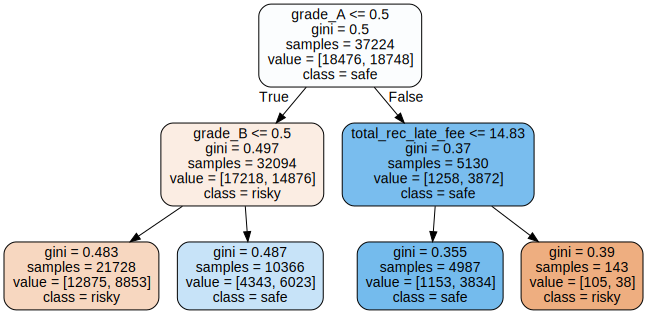

In [29]:
graphviz.Source(dot_graph)

grade_A = 0 : left side

grade_B = 0 : left side

We are selecting the leftmost leaf.

probability of safe = 8853/(12875+8853) = 0.4074466126656848

In [30]:
8853/(12875+8853)

0.4074466126656848

In [31]:
small_model.predict(sample_validation_data.drop('safe_loans',1).iloc[[1]])

array([-1], dtype=int64)

In [32]:
small_model.predict_proba(sample_validation_data.drop('safe_loans',1).iloc[[1]])[:,1]

array([0.40744661])

Note that probability of safe loan calculated using tree diagram and predict_proba are exactly equal.

#### Evaluating accuracy of the decision tree model

In [33]:
print("accuracy of decision_tree_model on the training data is",
      decision_tree_model.score(train_data.drop('safe_loans',1), train_data[target], sample_weight=None))

accuracy of decision_tree_model on the training data is 0.6405276165914464


In [34]:
print("accuracy of small_model on the training data is",
      small_model.score(train_data.drop('safe_loans',1), train_data[target], sample_weight=None))

accuracy of small_model on the training data is 0.6135020416935311


In [35]:
print("accuracy of decision_tree_model on the validation data data is",
      decision_tree_model.score(validation_data.drop('safe_loans',1), validation_data[target], sample_weight=None))

accuracy of decision_tree_model on the validation data data is 0.6363636363636364


In [36]:
print("accuracy of small_model on the valionidat data is",
      small_model.score(validation_data.drop('safe_loans',1), validation_data[target], sample_weight=None))

accuracy of small_model on the valionidat data is 0.6193451098664369


#### Evaluating accuracy of a complex decision tree model

In [37]:
big_model = DecisionTreeClassifier(max_depth=10)

In [38]:
big_model.fit(x, train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
big_model.score(train_data.drop('safe_loans',1), train_data[target], sample_weight=None)

0.6638459058671825

In [40]:
big_model.score(validation_data.drop('safe_loans',1), validation_data[target], sample_weight=None)

0.6261309780267126

big_model is overfit compare to decision_tree_model

#### Quantifying the cost of mistakes

In [41]:
validation_prediction = decision_tree_model.predict(validation_data.drop('safe_loans',1))

In [42]:
false_negative_counts = sum(validation_prediction < validation_data[target])

In [43]:
false_positive_counts = sum(validation_prediction > validation_data[target])

Let's assume that each mistake costs us money: a false negative costs \$10,000, while a false positive positive costs \$20,000.

In [44]:
total_cost = 10000*false_negative_counts + 20000*false_positive_counts

In [45]:
print("total cost is $"+str(total_cost))

total cost is $50370000


# Implementing binary decision trees from scratch

In [46]:
loans = pd.read_csv(r"D:\Classification\Project 4\data\lending-club-data.csv")

C:\Users\Govind\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
del loans['bad_loans']

In [48]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home_ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'

In [49]:
# Extract the feature columns and target column
loans = loans[features + [target]]

In [50]:
loans.head()

,grade,term,home_ownership,emp_length,safe_loans
0,B,36 months,RENT,10+ years,1
1,C,60 months,RENT,< 1 year,-1
2,C,36 months,RENT,10+ years,1
3,C,36 months,RENT,10+ years,1
4,A,36 months,RENT,3 years,1


#### One-hot encoding

In [51]:
categorical_var = [m for m in loans.columns if loans[m].dtypes == 'object']
categorical_var

['grade', 'term', 'home_ownership', 'emp_length']

In [52]:
loans=pd.get_dummies(loans)

In [53]:
loans.head()

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,-1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [54]:
with open(r"D:\Classification\Project 4\data\test-idx.json") as f:
    test_index=json.load(f)

In [55]:
train_data = loans.iloc[train_index]
test_data = loans.iloc[test_index]

#### Decision tree implementation

In [56]:
def intermediate_node_num_mistakes(labels_in_node):
    '''
    computes the number of misclassified examples of an intermediate node
    given the set of labels (y values) of the data points contained in the node.
    '''
    # Corner case: If labels_in_node is empty, return 0
    if len(labels_in_node) == 0:
        return 0    
    # number of safe loans
    num_safe_loans = sum(labels_in_node==1)   
    # number of risky loans
    num_risky_loans = sum(labels_in_node==-1)              
    # number of mistakes that the majority classifier makes.
    return min(num_safe_loans,num_risky_loans)  

In [57]:
# Test case 1
example_labels = pd.Series([-1, -1, 1, 1, 1])
if intermediate_node_num_mistakes(example_labels) == 2.:
    print('Test passed!')
else:
    print('Test 1 failed... try again!')

# Test case 2
example_labels = pd.Series([-1, -1, 1, 1, 1, 1, 1])
if intermediate_node_num_mistakes(example_labels) == 2:
    print('Test passed!')
else:
    print('Test 3 failed... try again!')
    
# Test case 3
example_labels = pd.Series([-1, -1, -1, -1, -1, 1, 1])
if intermediate_node_num_mistakes(example_labels) == 2:
    print('Test passed!')
else:
    print('Test 3 failed... try again!')

Test passed!
Test passed!
Test passed!


In [58]:
def best_splitting_feature(data, features, target):
    
    target_values = data[target]
    best_feature = None # Keep track of the best feature 
    best_error = 10     # Keep track of the best error so far 
    # Note: Since error is always <= 1, we should intialize it with something larger than 1.

    # Convert to float to make sure error gets computed correctly.
    num_data_points = float(len(data))  
    
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        left_split = data[data[feature] == 0]
        
        # The right split will have all data points where the feature value is 1
        right_split = data[data[feature] == 1]
            
        # the number of misclassified examples in the left split.
        left_mistakes =  intermediate_node_num_mistakes(left_split[target])           

        # the number of misclassified examples in the right split.
        right_mistakes = intermediate_node_num_mistakes(right_split[target])
            
        # the classification error of this split.
        error = (left_mistakes+right_mistakes)/num_data_points
        
        if error < best_error:
            best_error=error
            best_feature=feature
    
    return best_feature

In [59]:
def create_leaf(target_values):    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'is_leaf': True }
   
    # Count the number of data points that are +1 and -1 in this node.
    num_ones = len(target_values[target_values == +1])
    num_minus_ones = len(target_values[target_values == -1])    

    # For the leaf node, set the prediction to be the majority class.
    if num_ones > num_minus_ones:
        leaf['prediction'] = 1
    else:
        leaf['prediction'] = -1

    return leaf 

In [60]:
def decision_tree_create(data, features, target, current_depth = 0, max_depth = 10):
    remaining_features = features[:] 
    
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    

    # Check if there are mistakes at current node.
    if  intermediate_node_num_mistakes(target_values) == 0:
        print("Stopping condition 1 reached.")
        # If not mistakes at current node, make current node a leaf node
        return create_leaf(target_values)
    
    # check if there are remaining features to consider splitting on
    if remaining_features == []:   
        print("Stopping condition 2 reached.")    
        # If there are no remaining features to consider, make current node a leaf node
        return create_leaf(target_values)    
    
    # limit tree depth
    if current_depth >= max_depth:
        print("Reached maximum depth. Stopping for now.")
        # If the max tree depth has been reached, make current node a leaf node
        return create_leaf(target_values)

    splitting_feature=best_splitting_feature(data,features,target)
    
    # Split on the best feature
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    remaining_features.remove(splitting_feature)
    print("Split on feature %s. (%s, %s)" % (\
                      splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target])
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target])

        
    # recurse on left and right subtrees
    left_tree = decision_tree_create(left_split, remaining_features, target, current_depth + 1, max_depth)        
    right_tree = decision_tree_create(right_split, remaining_features, target, current_depth + 1, max_depth)

    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [61]:
features_new = [col for col in train_data.drop('safe_loans',1).columns]

In [62]:
my_decision_tree = decision_tree_create(train_data, features_new, target, current_depth = 0, max_depth = 6)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Split on feature grade_B. (8074, 1048)
--------------------------------------------------------------------
Subtree, depth = 3 (8074 data points).
Split on feature grade_C. (5884, 2190)
--------------------------------------------------------------------
Subtree, depth = 4 (5884 data points).
Split on feature grade_D. (3826, 2058)
--------------------------------------------------------------------
Subtree, depth = 5 (3826 data points).
Split on feature grade_E. (1693, 2133)
--------------------------------------------------------------------
Subtree, depth = 6 (1693 data points).
R

#### Making predictions with a decision tree

In [63]:
def classify(tree, x, annotate = False):
    # if the node is a leaf node.
    if tree['is_leaf']:
        if annotate:
             print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction']
    else:
        # split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate:
             print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)               

In [64]:
print(test_data.iloc[0])
print("--------")
print('Predicted class: %s ' % classify(my_decision_tree, test_data.iloc[0]))

safe_loans                -1
grade_A                    0
grade_B                    0
grade_C                    0
grade_D                    1
grade_E                    0
grade_F                    0
grade_G                    0
term_ 36 months            0
term_ 60 months            1
home_ownership_MORTGAGE    0
home_ownership_OTHER       0
home_ownership_OWN         0
home_ownership_RENT        1
emp_length_1 year          0
emp_length_10+ years       0
emp_length_2 years         1
emp_length_3 years         0
emp_length_4 years         0
emp_length_5 years         0
emp_length_6 years         0
emp_length_7 years         0
emp_length_8 years         0
emp_length_9 years         0
emp_length_< 1 year        0
Name: 24, dtype: int64
--------
Predicted class: -1 


In [65]:
type(test_data.iloc[0])

pandas.core.series.Series

In [66]:
classify(my_decision_tree, test_data.iloc[0], annotate=True)

Split on term_ 36 months = 0
Split on grade_A = 0
Split on grade_B = 0
Split on grade_C = 0
Split on grade_D = 1
At leaf, predicting -1


-1

#### Evaluating your decision tree

In [67]:
def evaluate_classification_error(tree, data):
    prediction = data.apply(lambda x: classify(tree, x),axis=1)
    classification_error = sum(prediction != data['safe_loans'])/len(data)
    return classification_error

In [68]:
print("accuracy on test data is",
      evaluate_classification_error(my_decision_tree, test_data))

accuracy on test data is 0.37774666092201636


#### Printing out a decision stump

In [71]:
def print_stump(tree, name = 'root'):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print("(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('_')
    print('                       %s' % name)
    print('         |---------------|----------------|')
    print('         |                                |')
    print('         |                                |')
    print('         |                                |')
    print('  [{0} == 0]               [{0} == 1]    '.format(split_name))
    print('         |                                |')
    print('         |                                |')
    print('         |                                |')
    print('    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

leftmost branch

In [72]:
print_stump(my_decision_tree)

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]               [term_ 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (subtree)


In [73]:
print_stump(my_decision_tree['left'], my_decision_tree['splitting_feature'])

                       term_ 36 months
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]               [grade_A == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (subtree)


In [74]:
print_stump(my_decision_tree['left']['left'], my_decision_tree['left']['splitting_feature'])

                       grade_A
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_B == 0]               [grade_B == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (subtree)


rightmost branch

In [76]:
print_stump(my_decision_tree['right'], my_decision_tree['splitting_feature'])

                       term_ 36 months
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_D == 0]               [grade_D == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (leaf, label: -1)


In [77]:
print_stump(my_decision_tree['right']['right'], my_decision_tree['right']['splitting_feature'])

(leaf, label: -1)
